# Construction of fragility corresponding to vulnerability

### Need to amend the vulnerability curve

In [1]:
%matplotlib inline

Now import the required modules to allow plotting, loading data, generating the curves and interacting with them.

In [2]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn
seaborn.set_context("poster")

# Import widgets for interactive notebook
from IPython.html.widgets import interact, fixed, interactive
from IPython.html import widgets
from IPython.display import display

from StringIO import StringIO

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Original vulnerability curves

In [3]:
def compute_vulnerability(mmi, **kwargs):

	def inv_logit(x):
		return  np.exp(x)/(1.0 + np.exp(x)) 

	# assign loss ratio
	coef = {
		"t0":-8.56, 
		"t1": 0.92, 
		"t2": -4.82, 
		"t3": 2.74, 
		"t4": 0.49, 
		"t5": -0.31}

	flag_timber = kwargs['flag_timber']
	flag_pre = kwargs['flag_pre']

	mu = coef["t0"] +\
		coef["t1"]*mmi +\
		coef["t2"]*flag_timber +\
		coef["t3"]*flag_pre +\
		coef["t4"]*flag_timber*mmi +\
		coef["t5"]*flag_pre*mmi

	return inv_logit(mu)


In [4]:
mmi_range = np.arange(3.0, 10.0, 0.05)
vul = {}

vul.setdefault('Timber',{})['Pre1945'] = compute_vulnerability(
    mmi_range, flag_timber=1, flag_pre=1)
vul.setdefault('URM',{})['Pre1945'] = compute_vulnerability(
    mmi_range, flag_timber=0, flag_pre=1)
vul.setdefault('Timber',{})['Post1945'] = compute_vulnerability(
    mmi_range, flag_timber=1, flag_pre=0)
vul.setdefault('URM',{})['Post1945'] = compute_vulnerability(
    mmi_range, flag_timber=0, flag_pre=0)

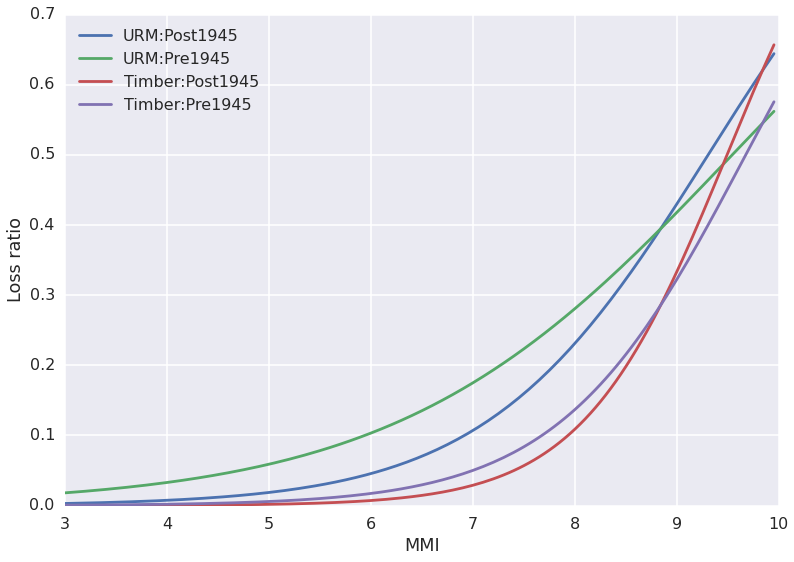

In [5]:
plt.figure()
for bldg in vul.keys():
    for age in vul[bldg].keys():
        str_ = "%s:%s" %(bldg, age)
        plt.plot(mmi_range, vul[bldg][age], label=str_)
plt.grid(1)
plt.legend(loc=2)
plt.xlabel('MMI')
plt.ylabel('Loss ratio')

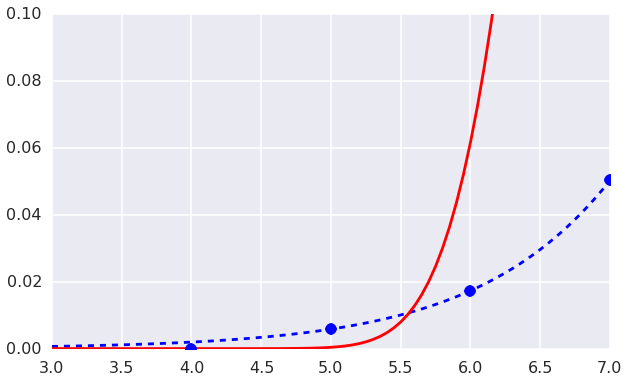

In [6]:
def fit_vul_lognorm(bldg_type, vintage, med, lnstd, xmax, ymax):
    
    vul_curves = vul[bldg_type][vintage]
    
    # only displays 5, 6, 7
    selected_mmi_pts= [5, 6, 7]
    selected_mmi_idx = [np.where(np.isclose(mmi_range,x))[0][0] 
                        for x in selected_mmi_pts]
    
    # Presented
    cdf_logcdf = stats.lognorm.cdf(mmi_range, lnstd, scale=med)
    
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot()
    ax.plot(mmi_range, vul_curves,'b--',
            mmi_range, cdf_logcdf, 'r-',
            4, 0.0, 'bo',
           selected_mmi_pts, vul_curves[selected_mmi_idx],'bo')
    ax.set_xlim([3, xmax])
    ax.set_ylim([0, ymax])

bldg_select = widgets.Dropdown(options=vul.keys(), value='Timber',
                             description="Bldg type")

vintage_select = widgets.Dropdown(options=vul['Timber'].keys(), value='Pre1945',
                             description="Vintage")

xmax_select = widgets.FloatSlider(min=7.0, 
                                     max=10, 
                                     step=0.5, 
                                     value=7.0, 
                                     description='xmax')

ymax_select = widgets.FloatSlider(min=0.05, 
                                     max=1.0, 
                                     step=0.05, 
                                     value=0.1, 
                                     description='ymax')

med_select = widgets.FloatSlider(min=4.0, 
                                     max=20, 
                                     step=0.1, 
                                     value=7, 
                                     description='median')

lnstd_select = widgets.FloatSlider(min=0.0, 
                                     max=1.0, 
                                     step=0.01, 
                                     value=0.1, 
                                     description='lnstd')

w = interactive(fit_vul_lognorm,
               bldg_type = bldg_select,
               vintage = vintage_select,
               xmax=xmax_select,
               ymax=ymax_select,
               med= med_select,
               lnstd = lnstd_select)
display(w)

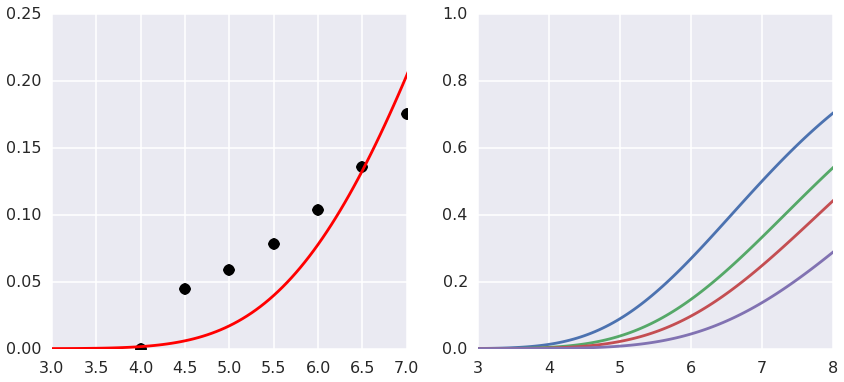

In [9]:
def creating_fragility(bldg_type, vintage, med_slt, med_mod, med_ext, med_cmp,
                      lnstd, xmax, ymax):

    import collections
    damage_to_loss = collections.OrderedDict((('slight', 0.02), ('moderate',0.10),
                                              ('extensive',0.5), ('complete',1.0)))

    med_frag = [med_slt, med_mod, med_ext, med_cmp]
    ds_str = ['slight', 'moderate', 'extensive', 'complete']
    
    frag_cdf = np.zeros((len(mmi_range), len(ds_str)))
    for (i, _) in enumerate(ds_str):
        frag_cdf[:, i] = stats.lognorm.cdf(mmi_range, lnstd, scale=med_frag[i])  
    
    # convert to pb
    pb = np.hstack((-1.0*np.diff(frag_cdf, axis=1), frag_cdf[:,-1][:, np.newaxis]))
    
    vul_est = np.dot(pb, np.array(damage_to_loss.values())[:,np.newaxis])
    
    med = {}
    med.setdefault('Timber',{})['Pre1945'] = 10.3
    med.setdefault('Timber',{})['Post1945'] = 11.2
    med.setdefault('URM',{})['Pre1945'] = 9.7
    med.setdefault('URM',{})['Post1945'] = 10.6

    lnstd = {}
    lnstd.setdefault('Timber',{})['Pre1945'] = 0.25
    lnstd.setdefault('Timber',{})['Post1945'] = 0.25
    lnstd.setdefault('URM',{})['Pre1945'] = 0.35
    lnstd.setdefault('URM',{})['Post1945'] = 0.35
    
    vul_curves = vul[bldg_type][vintage]
    
    # only displays 5, 6, 7
    selected_mmi_pts= [4.5, 5, 5.5,  6, 6.5, 7.0]
    selected_mmi_idx = [np.where(np.isclose(mmi_range,x))[0][0] 
                        for x in selected_mmi_pts]
    
    # Presented
    cdf_logcdf = stats.lognorm.cdf(mmi_range, 
                                   lnstd[bldg_type][vintage], 
                                   scale=med[bldg_type][vintage])
    
    fig = plt.figure(figsize=(14, 6))
    # vulnerability
    ax = plt.subplot(1, 2, 1)
    ax.plot(4, 0.0, 'ko',
           selected_mmi_pts, vul_curves[selected_mmi_idx],'ko',
           mmi_range, vul_est, 'r-')
    ax.set_xlim([3, 7])
    ax.set_ylim([0, ymax])

    ax = plt.subplot(1, 2, 2)
    ax.plot(mmi_range, frag_cdf)
    ax.set_xlim([3, xmax])
    ax.set_ylim([0, 1])
       
bldg_select = widgets.Dropdown(options=vul.keys(), value='Timber',
                             description="Bldg type")

vintage_select = widgets.Dropdown(options=vul['Timber'].keys(), value='Pre1945',
                             description="Vintage")

xmax_select = widgets.FloatSlider(min=7.0, 
                                     max=10, 
                                     step=0.5, 
                                     value=7.0, 
                                     description='xmax')

ymax_select = widgets.FloatSlider(min=0.05, 
                                     max=1.0, 
                                     step=0.05, 
                                     value=0.1, 
                                     description='ymax')

med_slt_select = widgets.FloatSlider(min=4.0, 
                                     max=20, 
                                     step=0.1, 
                                     value=7, 
                                     description='Slight')

med_mod_select = widgets.FloatSlider(min=4.0, 
                                     max=20, 
                                     step=0.1, 
                                     value=7, 
                                     description='Moderate')

med_ext_select = widgets.FloatSlider(min=4.0, 
                                     max=20, 
                                     step=0.1, 
                                     value=7, 
                                     description='Extensive')

med_cmp_select = widgets.FloatSlider(min=4.0, 
                                     max=20, 
                                     step=0.1, 
                                     value=7, 
                                     description='Complete')

lnstd_select = widgets.FloatSlider(min=0.0, 
                                     max=1.0, 
                                     step=0.01, 
                                     value=0.1, 
                                     description='lnstd')

w = interactive(creating_fragility,
               bldg_type = bldg_select,
               vintage = vintage_select,
               xmax=xmax_select,
               ymax=ymax_select,
               med_slt=med_slt_select,
               med_mod=med_mod_select,
                med_ext=med_ext_select,
                med_cmp=med_cmp_select,
               lnstd = lnstd_select)
display(w)

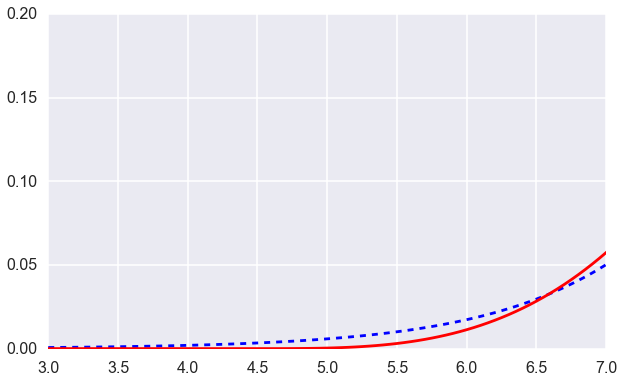

In [8]:
def fit_vul_weibull(bldg_type, vintage, shape, location, scale, xmax, ymax):
    
    vul_curves = vul[bldg_type][vintage]
    # Presented
    cdf_weibull = stats.exponweib.cdf(mmi_range, a=1, c=shape, loc=location, scale=scale)
    
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot()
    ax.plot(mmi_range, vul_curves,'b--',
            mmi_range, cdf_weibull, 'r-')
    ax.set_xlim([3, xmax])
    ax.set_ylim([0, ymax])

bldg_select = widgets.Dropdown(options=vul.keys(), value='Timber',
                             description="Bldg type")

vintage_select = widgets.Dropdown(options=vul['Timber'].keys(), value='Pre1945',
                             description="Vintage")

xmax_select = widgets.FloatSlider(min=7.0, 
                                     max=10, 
                                     step=0.5, 
                                     value=7.0, 
                                     description='xmax')

ymax_select = widgets.FloatSlider(min=0.05, 
                                     max=1.0, 
                                     step=0.05, 
                                     value=0.2, 
                                     description='ymax')

location_select = widgets.FloatSlider(min=3.0, 
                                     max=10, 
                                     step=0.05, 
                                     value=4.5, 
                                     description='location')

shape_select = widgets.FloatSlider(min=0.0, 
                                     max=20, 
                                     step=0.01, 
                                     value=6, 
                                     description='shape')

scale_select = widgets.FloatSlider(min=0.0, 
                                     max=20, 
                                     step=0.5, 
                                     value=9, 
                                     description='scale')

w = interactive(fit_vul_weibull,
               bldg_type = bldg_select,
               vintage = vintage_select,
               xmax=xmax_select,
               ymax=ymax_select,
               location= location_select,
               shape = shape_select,
               scale=scale_select)
display(w)

In [28]:
def fitweibull(bldg_type, vintage, param_lambda, param_k):

    from collections import OrderedDict
    
    ds_to_loss = 
    
    vul_curves = vul[bldg_type][vintage]
    plt.figure()
    plt.plot(mmi_range, vul_curves)
    plt.xlim([3, 7])
    #plt.ylim([0.0, 0.2])
    
#     frag=OrderedDict([('Slight', None), 
#                       ('Moderate', None), 
#                       ('Extensive', None), 
#                       ('Complete', None)])
    
#     for (ds, val) in zip(frag.keys(), median_frag, lnstd_frag):
#         frag[ds] = lognorm.cdf(mmi_range, val[1], scale=val[0])
        
#     # Set up the figure canvas:
#     fig = plt.figure(figsize=(16,8))
#     #gs = gridspec.GridSpec(2,6)
    
#     #ax1 = plt.subplot(gs[0:1,0:4])
#     #ax2 = plt.subplot(gs[-1,0:4])
#     #ax3 = plt.subplot(gs[0:2,4:])

#     ax = plt.subplot()
    
#     # Plot the fragility curves:
#     #ax1.fill_between(v, 0, ccdf, facecolor='k', alpha=0.25)
#     for ds in frag.keys():
#         ax.plot(mmi_range, frag[ds], label=ds)
    #ax1.fill_between(v, ccdf, ecdf, facecolor='r', alpha=0.25)
    #ax1.plot(v, ecdf, 'r', linewidth=1.)
    #ax1.fill_between(v, ecdf, mcdf, facecolor='b', alpha=0.25)
    #ax1.plot(v, mcdf, 'b', linewidth=1.)
    #ax1.fill_between(v, mcdf, scdf, facecolor='g', alpha=0.25)
    #ax1.plot(v, scdf, 'g', linewidth=1.)
    
    
    # Add annotations:
#     bbox = dict(facecolor='white', alpha=0.5)
#     cypos = lognorm.cdf(windspeed, bldcurves['cshape'], scale=bldcurves['cloc']) 
#     ax1.plot([windspeed, windspeed], [0,cypos], color='k', 
#              label="Complete: %.3f"%cypos)
    
#     if cypos > 0.05:
#         ax1.text(windspeed+2, cypos/2., "%.3f"%cypos, fontsize='small',
#                  color='k', ha='left', va='center', bbox=bbox)
        
#     eypos = lognorm.cdf(windspeed, bldcurves['eshape'], scale=bldcurves['eloc']) 
#     ax1.plot([windspeed, windspeed], [cypos,eypos], color='r', 
#              label="Extensive: %.3f"%(eypos - cypos))
    
#     if (eypos - cypos) > 0.05:
#         ax1.text(windspeed+2, (cypos+eypos)/2., "%.3f"%(eypos), 
#                  fontsize='small',color='r', ha='left', va='center', bbox=bbox)
        
#     mypos = lognorm.cdf(windspeed, bldcurves['mshape'], scale=bldcurves['mloc']) 
#     ax1.plot([windspeed, windspeed], [eypos,mypos], color='b', 
#              label="Moderate: %.3f"%(mypos - eypos))
#     if (mypos - eypos) > 0.05:
#         ax1.text(windspeed+2, (mypos+eypos)/2., "%.3f"%(mypos), 
#                  fontsize='small',color='b', ha='left', va='center', bbox=bbox)
        
#     sypos = lognorm.cdf(windspeed, bldcurves['sshape'], scale=bldcurves['sloc']) 
#     ax1.plot([windspeed, windspeed], [mypos,sypos], color='g', 
#              label="Slight: %.3f"%(sypos - mypos))
#     if (sypos - mypos) > 0.05:
#         ax1.text(windspeed+2, (sypos+mypos)/2., "%.3f"%(sypos), 
#                  fontsize='small',color='g', ha='left', va='center', bbox=bbox)
    
#     ax1.plot([windspeed, windspeed], [sypos,1.0], color='orange', 
#              label="No damage: %.3f"%(1.-sypos))
#     if sypos<0.95:
#         ax1.text(windspeed+2, (sypos+1.)/2., "%.3f"%(1.-sypos), 
#                  fontsize='small',color='brown', ha='left', va='center', bbox=bbox)
    
#     # Arrange the axis limits, labels, etc.
#     ax1.set_xlim((0,360))
#     ax1.set_xticks(np.arange(0, 361., 30))
#     ax1.set_ylim((0,1))
#     ax1.set_ylabel(r"$ P(D \geq ds) $")
#     ax1.set_xlabel("Wind speed (km/h)")
#     ax1.axvline(windspeed, color='k',linestyle=':')
#     ax1.grid(True)
    
#     l = ax1.legend(loc=2,frameon=True,)
        
#     ax1.set_title("Probability of damage states")
    
#     # Add the other plots:
#     problosshist(ax3, bldcurves, windspeed, dmgindex)
#     plotdamage(ax2, bldcurves, windspeed, dmgindex)
#     plotdamage_upd(ax2, bldcurves, windspeed, dmgindex)
    
#     ax2.grid(True)
#     ax2.set_title("Building damage ratio - %s"%buildingtype)
#     fig.tight_layout()

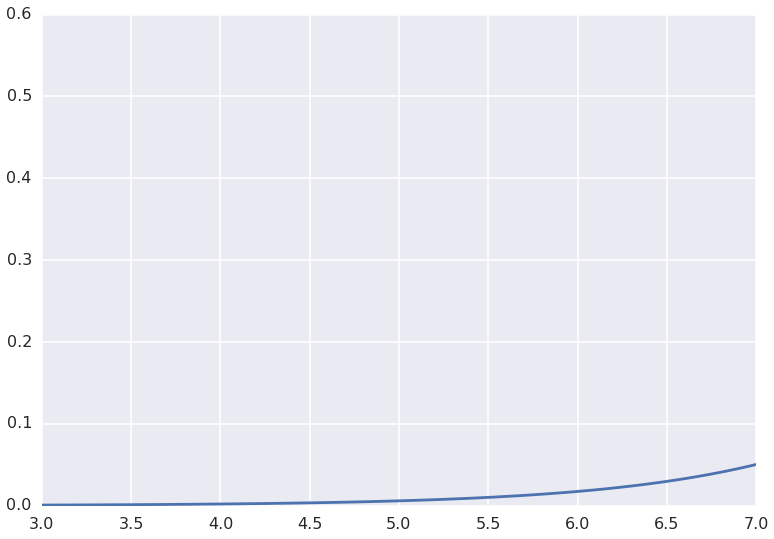

In [29]:
bldg_select = widgets.Dropdown(options=vul.keys(), value='Timber',
                             description="Bldg type")

vintage_select = widgets.Dropdown(options=vul['Timber'].keys(), value='Pre1945',
                             description="Vintage")

med_slt_select = widgets.FloatSlider(min=5.0, 
                                     max=7.0, 
                                     step=0.01, 
                                     value=7.0, 
                                     description='median Slight')
med_mod_select = widgets.FloatSlider(min=5.0, 
                                     max=7.0, 
                                     step=0.01, 
                                     value=7.0, 
                                     description='median Moderate')
med_ext_select = widgets.FloatSlider(min=5.0, 
                                     max=7.0, 
                                     step=0.01, 
                                     value=7.0, 
                                     description='median Extensive')
med_cmp_select = widgets.FloatSlider(min=5.0, 
                                     max=7.0, 
                                     step=0.01, 
                                     value=7.0, 
                                     description='median Complete')

#median_frag_select = [med_slt, med_mod, med_ext, med_cmp]

std_slt_select = widgets.FloatSlider(min=0.05, 
                                     max=0.2, 
                                     step=0.01, 
                                     value=0.1, 
                                     description='lnstd Slight')
std_mod_select = widgets.FloatSlider(min=0.05, 
                                     max=0.2, 
                                     step=0.01, 
                                     value=0.1, 
                                     description='lnstd Moderate')
std_ext_select = widgets.FloatSlider(min=0.05, 
                                     max=0.2, 
                                     step=0.01, 
                                     value=0.1, 
                                     description='lnstd Extensive')
std_cmp_select = widgets.FloatSlider(min=0.05, 
                                     max=0.2, 
                                     step=0.01, 
                                     value=0.1, 
                                     description='lnstd Complete')

#lnstd_frag_select = [std_slt, std_mod, std_ext, std_cmp]

w = interactive(plotcurve,
               bldg_type = bldg_select,
               vintage = vintage_select,
               med_slt = med_slt_select,
               lnstd_slt = std_slt_select,
               med_mod = med_mod_select,
               lnstd_mod = std_mod_select,
               med_ext = med_ext_select,
               lnstd_ext = std_ext_select,
               med_cmp = med_cmp_select,
               lnstd_cmp = std_cmp_select)
display(w)

The damage indices are building-specific. In some cases, the damage index for complete damage is < 1.0, which would be counterintuitive. For C1-M and S1-M, only window and roof components were considered, and so the damage index is scaled to reflect the proportional costs of those elements. 

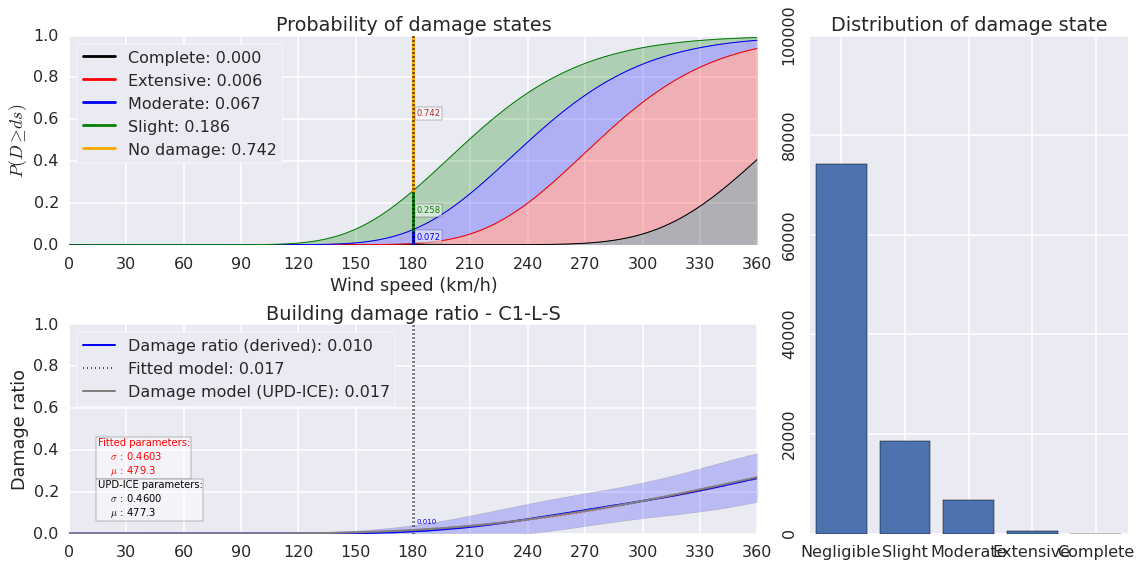

In [ ]:
seed = 10574

# Drop down menu to select the building type:
bldselect = widgets.Dropdown(options=bldtypes, value=bldtypes[0],
                             description="Building type")

# Slider widget to set the wind speed:
windselect = widgets.FloatSlider(min=0.0, max=360., step=1., value=180., 
                                 description="Wind speed (km/h)" )

w = interactive(plotcurve, 
                buildingtype=bldselect, 
                windspeed=windselect, 
                seed=fixed(seed))
display(w)

#### Full suite of vulnerability curves

Now we cycle through all available building types and fit a lognormal cdf to the derived damage curve. These can then be mapped to the corresponding building types in the full (>100) suite of building type & height combinations used in GMMA RAP to evaluate impacts to the built environment. The shape parameter should correspond to the 'sd' field in the suite of curves, and the scale corresponds to the 'mean' field.

In [ ]:
v = np.arange(0, 361., 1.)    
newcurves = dict()
print "Building type: shape  : scale  : UPD-ICE shape : UPD-ICE scale"
print "-------------------------------------------------------------- "
for bldtype in bldtypes:

    bldcurves = curves[bldtype]
    di = damageindex[bldtype]
    vcdf = bldcurves['vscale'] * lognorm.cdf(v, bldcurves['vshape'], 
                                              scale=bldcurves['vloc'])
    dmg_mean, dmg_sd = damage( v, bldcurves, di)
    xx = np.where(dmg_mean<=0.5)[0][-1]
    loc = v[xx]
    p = minimise(dmg_mean, bldcurves['vscale'], bldcurves['vshape'], loc)
    print "{0:<13s}: {1:.5f}: {2:<7.2f}: {3:14.2f}: {4:<10.2f}".format(bldtype, p[0], p[1], 
                                                                       bldcurves['vshape'], bldcurves['vloc'])
    newcurves[bldtype] = {'vshape':p[0], 'vloc':p[1]}

Building type: shape  : scale  : UPD-ICE shape : UPD-ICE scale
-------------------------------------------------------------- 
C1-L-S       : 0.46049: 479.35 :           0.46: 477.26    
C1-L-W       : 0.48363: 403.91 :           0.52: 416.41    
C1-M         : 0.43101: 248.30 :           0.33: 221.00    
CHB-L-S      : 0.38339: 423.32 :           0.44: 469.00    
CHB-L-W      : 0.58518: 450.05 :           0.59: 455.00    
CWS-L-S      : 0.20857: 452.15 :           0.16: 398.00    
CWS-L-W      : 0.60730: 394.79 :           0.52: 321.00    
MWS-L-S      : 0.20777: 451.61 :           0.16: 398.00    
MWS-L-W      : 0.60718: 394.83 :           0.52: 321.00    
N-L          : 0.34572: 194.74 :           0.20: 136.00    
S1-L         : 0.72482: 425.84 :           0.61: 379.10    
S1-M         : 0.23356: 177.59 :           0.24: 180.00    

We'll plot all the curves together to see how the derived curves compare with the reported curves.

In [ ]:
fig, axes = plt.subplots(len(bldtypes)/3, 3,sharex=True,sharey=True,figsize=(18,15))
x = np.arange(0, 360., 1.)

for ax, bldtype in zip(axes.ravel(), bldtypes):
    bldcurves = curves[bldtype]
    ncurves = newcurves[bldtype]
    vcdf = bldcurves['vscale'] * lognorm.cdf(x, bldcurves['vshape'], scale=bldcurves['vloc'])
    ncdf = bldcurves['vscale'] * lognorm.cdf(x, ncurves['vshape'], scale=ncurves['vloc'])
    ax.plot(x, ncdf, linewidth=2, label="Derived")
    ax.plot(x, vcdf, linewidth=1.5, linestyle='--',label="UPD-ICE")
    ax.set_ylabel(bldtype)
    
    ax.set_xlim((0,360))
    ax.set_xticks(np.arange(0, 361., 60))
    ax.set_ylim((0,1))

axes.ravel()[-2].set_xlabel("Wind speed (km/h)")
l = ax.legend(loc=0, frameon=True,)

### Conclusions

Most of the derived vulnerability models closely match the reported models. Curves where there is little damage below 240 km/h result in a poorer match, largely because there are fewer non-zero data points to fit against. There may be opportunity to review the underlying fragility curves for these building types to consider the level of damage sustained at high wind speeds. 

Also there are some building types where the damage index assigned to a complete damage state is not 1.0. Excluding those building types where only damage to windows and roofs are considered (C1-M and S1-M), this will lead to situations where the complete damage state is reached throughout a population of buildings, but the damage index is not 1.0. 

The W3-L, W1-L and N-L buildings are significantly different from the reported curves. This is because the derived curves were considered too strong and replaced with empirical curves based on discussion with local builders & carpenters. It could be recommended to fit fragility curves to these empirical damage curves (e.g. usnig Geoscience Australia's eLoss tool). Also, the fragility curves for W3-L were not reported by UPD-ICE and were inferred from the N-L building type.

This document was written in an IPython notebook. The raw notebook can be downloaded [here](https://github.com/wcarthur/notebooks/blob/master/Vulnerability%20and%20fragility%20curves%20for%20GMMA.ipynb). See also [nbviewer](http://nbviewer.ipython.org/github/wcarthur/notebooks/blob/master/Vulnerability%20and%20fragility%20curves%20for%20GMMA.ipynb) for an online static view.